In [1]:
import data2D as data_import
import os
import matplotlib.pyplot as plt
import numpy as np

D = 1e-8
N = 16

plt.rcParams.update({'font.size': 20})
plt.rc('figure', figsize=(20, 10))


In [2]:
# 3.2 pico seconds for particle to travel L
def exec(dt=0.0001, dt2=0.1, tf=1e12, v=5e3, r=0):

    command = f"java -cp target/SimulacionTemporal-1.0-SNAPSHOT.jar \
                -Ddt={dt} -Ddt2={dt2} -Dtf={tf} \
                -Dv={v} -Dr={r} \
                ElectricFieldSystem"
    proc = os.popen(command)
    print(proc.readlines())
    proc.close()
    data = data_import.Data("ElectricField.txt")
    return data


In [3]:
def plot_particles():
    for i in range(N):
        for j in range(N):
            c = 'r' if (i+j)%2 == 0 else 'b'
            plt.scatter((i+1)*D, j*D, c=c, s=100)

['Particle escaped!\n']


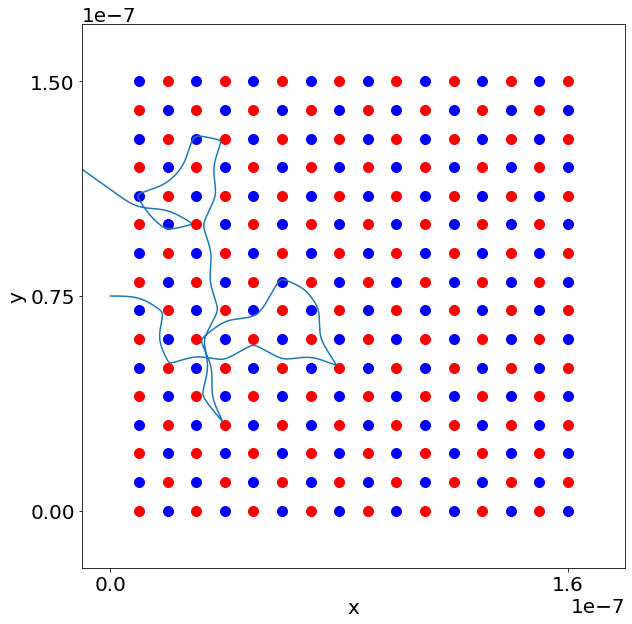

In [20]:
X = []
Y = []

data = exec(r=0, dt=0.0001, dt2=0.001, v=10e3)
for t, x, y, vx, vy in data:
    X.append(x)
    Y.append(y)

plt.figure("Trajectory")
plot_particles()
plt.plot(X, Y, "-", markersize=1)
plt.xticks([0, N*D])
plt.yticks([0,(N-1)*D/2, N*D -D])
plt.ylim(-2*D, N*D + D)
plt.xlim(-D, N*D + 2*D)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
#plt.grid()

plt.show()
